In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set()

In [4]:
import sys
sys.path.append('../../')

import data_utils as util

## Load data

In [33]:
df = pd.read_csv('../../data/combined_full.csv', index_col=0, parse_dates=[1])
df.head()

,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug,gender,Age at diagnosis,patient_hla_bUnknown7_id,EIBP,patient_condition_subtype,Age,Age_cat
patient_id,,,,,,,,,,,,,,,
40,1995-05-09,3,1,6,5,3,3.6,False,Female,46.255989,Positive,False,AS,48,5.0
40,1995-06-01,3,1,8,5,3,4.0,False,Female,46.255989,Positive,False,AS,48,5.0
40,1995-06-12,2,1,5,3,2,2.6,False,Female,46.255989,Positive,False,AS,48,5.0
40,1995-11-02,1,1,3,4,2,2.2,False,Female,46.255989,Positive,False,AS,48,5.0
40,1996-05-02,2,1,4,3,2,2.4,False,Female,46.255989,Positive,False,AS,49,5.0


### Normalize patient timeline

In [25]:
def get_norm_years(dates):
    """
    Different from get_norm_years in data_utils
    
    ->  Calculates normlized timeline using start year as 0 
        and increments for each subsequent year
    
    ->  Originally increments for every year included in study
    
    For example, if patient joined in May 1995, next year increment would
    have been June 1996. Now it will increment on Jan 1996. 
    """
    
    years = [d.year for d in dates]
    start_year = min(years)
    norm_years = [year - start_year for year in years]
    
    return norm_years


df['norm_years'] = df.groupby(['patient_id'])['Date'].transform(get_norm_years)

df.head()

,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug,gender,Age at diagnosis,patient_hla_bUnknown7_id,EIBP,patient_condition_subtype,Age,Age_cat,norm_years
patient_id,,,,,,,,,,,,,,,,
40,1995-05-09,3,1,6,5,3,3.6,False,Female,46.255989,Positive,False,AS,48,5.0,0
40,1995-06-01,3,1,8,5,3,4.0,False,Female,46.255989,Positive,False,AS,48,5.0,0
40,1995-06-12,2,1,5,3,2,2.6,False,Female,46.255989,Positive,False,AS,48,5.0,0
40,1995-11-02,1,1,3,4,2,2.2,False,Female,46.255989,Positive,False,AS,48,5.0,0
40,1996-05-02,2,1,4,3,2,2.4,False,Female,46.255989,Positive,False,AS,49,5.0,1


### Aggregate by year in study

For each patient, calculate aggregated scores for every year in the study

* TODO - generalize this to be able to aggregate for other periods

In [26]:
def agg_by_norm_year(df, agg_dict={}):
    return df.groupby(['patient_id','norm_years']).agg(agg_dict)

# Aggregate the data for each patient by normalized year
# Keep the actual year of each norm_year
agg_dict={'BS': 'mean', 'Age': min, 'Drug': np.any, 'Date': lambda x: x.iloc[0].year}
agg_df = agg_by_norm_year(df,agg_dict).rename(columns={'Date': 'year'})

# Add Gender and Diagnosis Date to aggregated, normalized data
agg_df = demo_df.join(agg_df).reset_index().set_index('patient_id')


# Add time since diagnosis variable
agg_df['time_since_diagnosis'] = agg_df['year'] - agg_df['diagnosis_date'].dt.year
agg_df.drop('diagnosis_date', axis=1, inplace=True)

agg_df.to_csv('../../data/clean_full.csv')
agg_df.head(20)

,norm_years,gender,BS,Age,Drug,year,time_since_diagnosis
patient_id,,,,,,,
40,0,Female,3.100000,48,False,1995,1.0
40,1,Female,2.400000,49,False,1996,2.0
40,2,Female,3.000000,50,False,1997,3.0
40,3,Female,3.400000,51,False,1998,4.0
40,4,Female,3.300000,52,False,1999,5.0
40,5,Female,3.200000,53,False,2000,6.0
40,6,Female,3.000000,54,False,2001,7.0
40,7,Female,3.750000,55,False,2002,8.0
40,8,Female,2.900000,56,False,2003,9.0


# Implement LMM 

Start with using `Drug` and `norm_years` as the predictors and using `BS` as the outcome. 

Thus, we have:

\begin{equation}
\mathbf{y} = \mathbf{X}\mathbf{\beta} + \mathbf{Z}\mathbf{u} + \mathbf{\epsilon}
\end{equation}

In [27]:
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

ids_list = agg_df.index 
patient_ids = ids_list.unique()

n_patients = len(patient_ids)
n_samples = agg_df.shape[0]

ids_to_idx = {p_id:idx for idx,p_id in enumerate(patient_ids)}
samples_idx = list(range(n_samples))

y = agg_df['BS'].values

In [28]:
results = {
    'time': {},
    'time+drugs': {},
}

Start with only modelling time as a fixed effect ("norm_years")

In [29]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

lm = smf.mixedlm('BS ~ norm_years', agg_df, groups=ids_list)

result = lm.fit()

params = result.params

results['time']['intercept'] = params['Intercept']
results['time']['norm_years'] = params['norm_years']
results['time']['groups_RE'] = params['groups RE']

result.summary()

/Users/renierbotha/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: BS        
No. Observations: 8472    Method:             REML      
No. Groups:       688     Scale:              0.4044    
Min. group size:  1       Likelihood:         -9758.0802
Max. group size:  31      Converged:          Yes       
Mean group size:  12.3                                  
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      3.232    0.076 42.344 0.000  3.083  3.382
norm_years     0.040    0.001 37.358 0.000  0.038  0.042
groups RE      3.899    0.351                           
========================================================

"""

In [30]:
lm = smf.mixedlm('BS ~ norm_years + norm_years ^ 2 + gender', agg_df, groups=ids_list)

result = lm.fit()

params = result.params

for idx in params.index:
    results['time+drugs'][idx] = params[idx]

params

Intercept         2.603800
gender[T.Male]    0.808450
norm_years        0.041024
norm_years ^ 2   -0.000867
groups RE         9.375737
dtype: float64

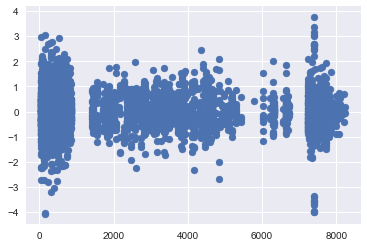

In [31]:
residuals = result.resid

plt.scatter(x=residuals.index, y=residuals.values)

In [32]:
x = range(min(agg_df['norm_years']), agg_df['norm_years'].max())

y1 = results['time']['intercept'] + x * results['time']['norm_years']

y2 = results['time+drugs']['intercept'] + x * results['time+drugs']['norm_years'] \
                                        + results['time+drugs']['Drug']

KeyError: 'intercept'

In [ ]:
plt.figure()
plt.plot(x, y1, label='time')
plt.plot(x, y2, label='time+drugs')
plt.legend(loc='lower right')
plt.show()